<a href="https://colab.research.google.com/github/senemcet/automlcourse/blob/main/301125.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U scikit-optimize
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler  #veriyi olceklendirmek icin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression   #lojistik regresyon modeli kullanılacak
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

#meme kanseri veri setini yükle
data=load_breast_cancer()
X=data.data
y=data.target

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.3 MB/s eta 0:00:00


In [ ]:
#pipeline ile uzay olusturma
pipeline=Pipeline([
    ('scaler',StandardScaler()),
    ('model',LogisticRegression(max_iter=2000))
])

#parametre dagilimi
search_spaces={
    "model__C": Real(1e-3, 1e3, prior="log-uniform"),
    "model__penalty":Categorical (["l2"]),
    "model__solver":Categorical(["lbfgs"])
}

In [ ]:
#bayes optimazasyonu ile en iyi parametreleri ara
opt= BayesSearchCV(
    estimator=pipeline, #uzerinde arama yapilacak model(pipeline)
    search_spaces=search_spaces,  #aranacak hiperparametre araliklari
    n_iter=30,
    cv=5,
    scoring="accuracy",
    n_jobs=-1, #tum islemci cekirdeklerini kullan
    random_state=42
)

opt.fit(X,y)

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                        ('model',
                                         LogisticRegression(max_iter=2000))]),
              n_iter=30, n_jobs=-1, random_state=42, scoring='accuracy',
              search_spaces={'model__C': Real(low=0.001, high=1000.0, prior='log-uniform', transform='normalize'),
                             'model__penalty': Categorical(categories=('l2',), prior=None),
                             'model__solver': Categorical(categories=('lbfgs',), prior=None)})

In [ ]:
import pandas as pd

#tum deneylerin sonuclari dataframe alinir
results=pd.DataFrame(opt.cv_results_)
print(results[["params","mean_test_score","rank_test_score"]].sort_values(by="rank_test_score").head())
#sadece gormek istedigimiz sutunlari yazdiriyoruz
#params:denenen hiperparametreler
#mean_test_score:her bir kombinasyonun ortalama doğruluk skoru
#rank_test_score:skor sıralaması(1en iyi)

print("en iyi parametreler:",opt.best_params_)
print("en iyi skor:",opt.best_score_)
print("en iyi model:", opt.best_estimator_)

                                               params  mean_test_score  \
13  {'model__C': 0.7823086048734879, 'model__penal...         0.980686   
11  {'model__C': 0.8690904643609954, 'model__penal...         0.980686   
20  {'model__C': 0.854106496225252, 'model__penalt...         0.980686   
16  {'model__C': 0.9283242237084505, 'model__penal...         0.980686   
29  {'model__C': 0.5043678063439685, 'model__penal...         0.980686   

    rank_test_score  
13                1  
11                1  
20                1  
16                1  
29                1  
en iyi parametreler: OrderedDict({'model__C': 0.8690904643609954, 'model__penalty': 'l2', 'model__solver': 'lbfgs'})
en iyi skor: 0.9806862288464524
en iyi model: Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(C=0.8690904643609954, max_iter=2000))])


In [ ]:
#Tpe

!pip install hyperopt

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import numpy as np

data= load_breast_cancer()
X=data.data
y=data.target

In [ ]:
#arama uzayi olusturma

from hyperopt import hp,fmin,tpe,Trials

space={
    "C":hp.loguniform("C", np.log(1e-3), np.log(1e3)),
    "solver":hp.choice("solver",["lbfgs"]),
    "penalty":hp.choice("penalty",["l2"])
}

In [ ]:
#nesne olusturma fonks

def objective(params):
  #verilen hiperparametrelerle Logistic Regression modeli oluşturuyoruz
  model=LogisticRegression(
      C=params["C"],
      solver=params["solver"],
      penalty=params["penalty"],
      max_iter=2000
  )

  scaler=StandardScaler()
  X_scaled=scaler.fit_transform(X)
  score=cross_val_score(model,X_scaled,y,cv=5,scoring="accuracy").mean()

  return -score  #cunku hyperopt minimize eder


In [ ]:
trials = Trials()

best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,   # TPE'nin kendisi
    max_evals=30,       # 30 deneme
    trials=trials,
    rstate=np.random.default_rng(42)
)

100%|██████████| 30/30 [00:04<00:00,  6.41trial/s, best loss: -0.9824406148113646]


In [ ]:
#sonuçlar
#--------------------------------------------------
#trials_results = sorted(trials.results, key=lambda x: x["loss"])
print(trials.results)  # en iyi 5 deneme
print("En iyi hiperparametreler:", best)

[{'loss': -0.9613879832324173, 'status': 'ok'}, {'loss': -0.9754075454122031, 'status': 'ok'}, {'loss': -0.9455364073901569, 'status': 'ok'}, {'loss': -0.9824406148113646, 'status': 'ok'}, {'loss': -0.9789318428815402, 'status': 'ok'}, {'loss': -0.9648967551622419, 'status': 'ok'}, {'loss': -0.9648967551622419, 'status': 'ok'}, {'loss': -0.9297469337059463, 'status': 'ok'}, {'loss': -0.9648967551622419, 'status': 'ok'}, {'loss': -0.9754075454122031, 'status': 'ok'}, {'loss': -0.915711845986648, 'status': 'ok'}, {'loss': -0.9648967551622419, 'status': 'ok'}, {'loss': -0.9736531594472908, 'status': 'ok'}, {'loss': -0.9315168452103709, 'status': 'ok'}, {'loss': -0.9648812296227295, 'status': 'ok'}, {'loss': -0.9613879832324173, 'status': 'ok'}, {'loss': -0.9613879832324173, 'status': 'ok'}, {'loss': -0.9754075454122031, 'status': 'ok'}, {'loss': -0.9701443875174662, 'status': 'ok'}, {'loss': -0.9789318428815401, 'status': 'ok'}, {'loss': -0.9719142990218911, 'status': 'ok'}, {'loss': -0.9

In [ ]:
############    Optuna   #################
!pip install optuna

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import numpy as np

# Veri yükleme
data = load_breast_cancer()
X, y = data.data, data.target


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 8.4 MB/s eta 0:00:00


In [ ]:
#nesne fonksiyonu olusturma
#-------------------------------------------------
import optuna

def objective(trial):

    # Hiperparametreler trial ile seçilir
    C = trial.suggest_loguniform("C", 1e-3, 1e3)
    solver = trial.suggest_categorical("solver", ["lbfgs"])
    penalty = trial.suggest_categorical("penalty", ["l2"])

    # Model
    model = LogisticRegression(
        C=C,
        solver=solver,
        penalty=penalty,
        max_iter=2000
    )

    # Scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # CV Skor
    score = cross_val_score(model, X_scaled, y, cv=5, scoring="accuracy").mean()

    return score   # maximize edeceğiz

In [ ]:
#aramayı başlat
#--------------------------------------------------
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

[I 2025-12-03 09:49:57,172] A new study created in memory with name: no-name-aaded832-f084-4e08-acf0-6892a13fe83f
/tmp/ipython-input-240197979.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-3, 1e3)
[I 2025-12-03 09:49:57,209] Trial 0 finished with value: 0.9771619313771154 and parameters: {'C': 0.15604620517162862, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 0 with value: 0.9771619313771154.
/tmp/ipython-input-240197979.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-3, 1e3)
[I 2025-12-03 09:49:57,497] Trial 1 finished with value: 0.9613879832324173 and parameters: {'C': 429.259548

In [ ]:
#sonuçlar
#--------------------------------------------------
print("En iyi skor:", study.best_value)
print("En iyi parametreler:", study.best_params)
optuna.visualization.plot_param_importances(study)
optuna.visualization.plot_optimization_history(study)

En iyi skor: 0.9806862288464524
En iyi parametreler: {'C': 0.5917177704857035, 'solver': 'lbfgs', 'penalty': 'l2'}


In [ ]:
############# Pipeline #######################
# Pipeline + Optuna ile Logistic Regression HPO
# Breast Cancer veri seti (sklearn)

!pip install optuna -q

import optuna
import numpy as np
import pandas as pd

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

#veri setini yükle
data = load_breast_cancer()
X, y = data.data, data.target

In [ ]:
#Optuna objective fonksiyonu
#    - Pipeline burada kuruluyor
#    - Arama uzayı geniş: C, penalty, l1_ratio, class_weight, max_iter
def objective(trial):

    # C: log-uniform aralıkta (0.0001 - 1000)
    C = trial.suggest_float("C", 1e-1, 1, log=True)

    # penalty: saga solver ile uyumlu olacak şekilde seçiyoruz
    penalty = trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet"])

    # elasticnet için l1_ratio (sadece penalty='elasticnet' ise anlamlı)
    l1_ratio = None
    if penalty == "elasticnet":
        l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)

    # class_weight: dengesiz veri için opsiyonel
    class_weight = trial.suggest_categorical("class_weight", [None, "balanced"])

    # max_iter: yakınsamayı garanti altına almak için arayalım
    max_iter = trial.suggest_int("max_iter", 500, 3000, step=500)

    # -----------------------------
    # pipeline tanımı
    #    scaler + LogisticRegression
    #    - scaler: StandardScaler
    #    - model: LogisticRegression(saga)  -> hem l1, hem l2, hem elasticnet destekli
    # -----------------------------
    if penalty == "elasticnet":
        model = LogisticRegression(
            C=C,
            penalty=penalty,
            l1_ratio=l1_ratio,
            solver="saga",
            class_weight=class_weight,
            max_iter=max_iter,
            n_jobs=-1
        )
    else:
        model = LogisticRegression(
            C=C,
            penalty=penalty,
            solver="saga",
            class_weight=class_weight,
            max_iter=max_iter,
            n_jobs=-1
        )

    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model)
    ])

    # -----------------------------
    # 4) CV skoru (5-fold, accuracy)
    # -----------------------------
    score = cross_val_score(
        pipeline,
        X, y,
        cv=5,
        scoring="accuracy",
        n_jobs=-1
    ).mean()

    # Optuna varsayılan olarak "maximize" ya da "minimize" diyebiliyor.
    # Biz study'de direction="maximize" diyeceğimiz için direkt score döndürüyoruz.
    return score


In [ ]:
#Optuna çalıştırma
study = optuna.create_study(
    study_name="breast_cancer_pipeline_logreg",
    direction="maximize"  # accuracy'yi maksimize edeceğiz
)

# n_trials: deneme sayısı (daha fazla deneme = daha iyi sonuç, daha uzun süre)
study.optimize(objective, n_trials=50, show_progress_bar=True)


#sonuçların özeti

print("En iyi skor (CV accuracy):", study.best_value)
print("En iyi hiperparametreler:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

#isteğe bağlı: tüm denemeleri DataFrame olarak görmek için
trials_df = study.trials_dataframe()
display(trials_df.sort_values("value", ascending=False).head())

[I 2025-12-03 09:50:20,907] A new study created in memory with name: breast_cancer_pipeline_logreg


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-03 09:50:21,303] Trial 0 finished with value: 0.9771619313771154 and parameters: {'C': 0.12753785455164848, 'penalty': 'l2', 'class_weight': None, 'max_iter': 2500}. Best is trial 0 with value: 0.9771619313771154.
[I 2025-12-03 09:50:27,226] Trial 1 finished with value: 0.9665890389691041 and parameters: {'C': 0.1486931538911405, 'penalty': 'l1', 'class_weight': 'balanced', 'max_iter': 2500}. Best is trial 0 with value: 0.9771619313771154.
[I 2025-12-03 09:50:30,026] Trial 2 finished with value: 0.9683589504735289 and parameters: {'C': 0.12281980072218876, 'penalty': 'l1', 'class_weight': 'balanced', 'max_iter': 1000}. Best is trial 0 with value: 0.9771619313771154.
[I 2025-12-03 09:50:30,836] Trial 3 finished with value: 0.9754075454122031 and parameters: {'C': 0.44099217370536753, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 1500}. Best is trial 0 with value: 0.9771619313771154.
[I 2025-12-03 09:50:33,230] Trial 4 finished with value: 0.9736376339077782 and par

,number,value,datetime_start,datetime_complete,duration,params_C,params_class_weight,params_l1_ratio,params_max_iter,params_penalty,state
12,12,0.980686,2025-12-03 09:50:43.274174,2025-12-03 09:50:44.508203,0 days 00:00:01.234029,0.949568,None,0.015077,3000,elasticnet,COMPLETE
13,13,0.980686,2025-12-03 09:50:44.510936,2025-12-03 09:50:45.314807,0 days 00:00:00.803871,0.900996,None,0.030788,3000,elasticnet,COMPLETE
11,11,0.980686,2025-12-03 09:50:41.564915,2025-12-03 09:50:43.271097,0 days 00:00:01.706182,0.957699,None,0.028544,3000,elasticnet,COMPLETE
10,10,0.980686,2025-12-03 09:50:39.886639,2025-12-03 09:50:41.554264,0 days 00:00:01.667625,0.821094,None,0.102090,3000,elasticnet,COMPLETE
41,41,0.980686,2025-12-03 09:51:23.803271,2025-12-03 09:51:24.589321,0 days 00:00:00.786050,0.869875,None,0.000024,3000,elasticnet,COMPLETE


In [ ]:
############### PBT ####################

# PBT benzeri basit örnek:
# Breast Cancer veri seti üzerinde 3 farklı model yarışıyor
# (LogisticRegression, RandomForest, SVC)
# Nesiller boyunca en iyi model tipi + hiperparametreler evrimleşiyor

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

#veri setini yükle ve train/val olarak böl
data = load_breast_cancer()
X, y = data.data, data.target

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
#bir bireyi değerlendir (model tipi + hiperparametreler)
def evaluate_individual(individual):
    """
    individual sözlüğü:
    {
        "id": int,
        "model_type": "logreg" | "rf" | "svc",
        "params": {...}
    }
    Bu fonksiyon pipeline oluşturur, modeli eğitir ve val accuracy döndürür.
    """
    model_type = individual["model_type"]
    params = individual["params"]

    if model_type == "logreg":
        # Logistic Regression (L2, lbfgs)
        model = LogisticRegression(
            C=params["C"],
            solver="lbfgs",
            penalty="l2",
            max_iter=2000
        )
        # LogReg ölçeklendirmeden faydalanır
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("model", model)
        ])

    elif model_type == "rf":
        # Random Forest
        model = RandomForestClassifier(
            n_estimators=params["n_estimators"],
            max_depth=params["max_depth"],
            random_state=42
        )
        # RF genelde scaling istemez ama pipeline için tutarlılık olsun:
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("model", model)
        ])

    elif model_type == "svc":
        # SVC (RBF kernel)
        model = SVC(
            C=params["C"],
            gamma=params["gamma"],
            kernel="rbf"
        )
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("model", model)
        ])
    else:
        raise ValueError("Bilinmeyen model tipi!")

    pipe.fit(X_train, y_train)
    score = pipe.score(X_val, y_val)
    return score


In [ ]:
#Başlangıç popülasyonu: 3 farklı model tipi
population = [
    {
        "id": 0,
        "model_type": "logreg",
        "params": {"C": 0.1}
    },
    {
        "id": 1,
        "model_type": "rf",
        "params": {"n_estimators": 100, "max_depth": 5}
    },
    {
        "id": 2,
        "model_type": "svc",
        "params": {"C": 1.0, "gamma": 0.01}
    }
]

In [ ]:
n_generations = 10  # nesil sayısı

# Loglama yapıları: skor + ana hiperparametre
scores_history = {ind["id"]: [] for ind in population}
main_hp_history = {ind["id"]: [] for ind in population}
model_type_history = {ind["id"]: [] for ind in population}
best_history = []

# PBT döngüsü

for gen in range(n_generations):
    print(f"\n=== Nesil {gen} ===")

    # Her bireyi değerlendir
    for ind in population:
        score = evaluate_individual(ind)
        ind["score"] = score

        # Loglama
        scores_history[ind["id"]].append(score)
        model_type_history[ind["id"]].append(ind["model_type"])

        # Görselleştirme için "ana hiperparametre" seçelim:
        if ind["model_type"] == "logreg":
            main_hp_history[ind["id"]].append(ind["params"]["C"])
            hp_str = f"C={ind['params']['C']:.5f}"
        elif ind["model_type"] == "rf":
            main_hp_history[ind["id"]].append(ind["params"]["n_estimators"])
            hp_str = f"n_estimators={ind['params']['n_estimators']}"
        else:  # svc
            main_hp_history[ind["id"]].append(ind["params"]["C"])
            hp_str = f"C={ind['params']['C']:.5f}"

        print(f"Birey {ind['id']} | Tip={ind['model_type']} | {hp_str} | "
              f"Doğruluk={score:.4f}")

    # Nesil sonu: en iyi ve en kötü bireyi bul
    population_sorted = sorted(population, key=lambda x: x["score"], reverse=True)
    best = population_sorted[0]
    worst = population_sorted[-1]
    best_history.append(best["score"])

    print(f"-> En iyi birey: {best['id']} "
          f"(Tip={best['model_type']}, skor={best['score']:.4f})")

    # --- PBT adımı: Exploit + Explore ---
    # En kötü bireyi en iyi bireyin kopyası yap (exploit)
    # Sonra kopyalanan bireyin hiperparametrelerini hafifçe değiştir (mutasyon = explore)

    print(f"Birey {worst['id']} sömürülüyor: "
          f"eski tip={worst['model_type']} -> yeni tip={best['model_type']}")

    worst["model_type"] = best["model_type"]
    worst["params"] = best["params"].copy()  # parametreleri kopyala

    # Mutasyon (model tipine göre farklı hiperparametre mutasyonu)
    if worst["model_type"] == "logreg":
        old_C = worst["params"]["C"]
        factor = np.random.uniform(0.5, 2.0)
        new_C = np.clip(old_C * factor, 1e-4, 1e3)
        worst["params"]["C"] = float(new_C)
        print(f"  -> Mutasyon (LogReg): C {old_C:.5f} -> {new_C:.5f}")

    elif worst["model_type"] == "rf":
        old_n = worst["params"]["n_estimators"]
        # n_estimators etrafında +/- 50 adımlı bir mutasyon
        delta = np.random.randint(-50, 51)
        new_n = int(np.clip(old_n + delta, 10, 500))
        worst["params"]["n_estimators"] = new_n
        print(f"  -> Mutasyon (RF): n_estimators {old_n} -> {new_n}")

    elif worst["model_type"] == "svc":
        old_C = worst["params"]["C"]
        factor = np.random.uniform(0.5, 2.0)
        new_C = np.clip(old_C * factor, 1e-3, 1e3)
        worst["params"]["C"] = float(new_C)
        print(f"  -> Mutasyon (SVC): C {old_C:.5f} -> {new_C:.5f}")


=== Nesil 0 ===
Birey 0 | Tip=logreg | C=0.10000 | Doğruluk=0.9737
Birey 1 | Tip=rf | n_estimators=100 | Doğruluk=0.9561
Birey 2 | Tip=svc | C=1.00000 | Doğruluk=0.9825
-> En iyi birey: 2 (Tip=svc, skor=0.9825)
Birey 1 sömürülüyor: eski tip=rf -> yeni tip=svc
  -> Mutasyon (SVC): C 1.00000 -> 0.54491

=== Nesil 1 ===
Birey 0 | Tip=logreg | C=0.10000 | Doğruluk=0.9737
Birey 1 | Tip=svc | C=0.54491 | Doğruluk=0.9649
Birey 2 | Tip=svc | C=1.00000 | Doğruluk=0.9825
-> En iyi birey: 2 (Tip=svc, skor=0.9825)
Birey 1 sömürülüyor: eski tip=svc -> yeni tip=svc
  -> Mutasyon (SVC): C 1.00000 -> 0.76924

=== Nesil 2 ===
Birey 0 | Tip=logreg | C=0.10000 | Doğruluk=0.9737
Birey 1 | Tip=svc | C=0.76924 | Doğruluk=0.9649
Birey 2 | Tip=svc | C=1.00000 | Doğruluk=0.9825
-> En iyi birey: 2 (Tip=svc, skor=0.9825)
Birey 1 sömürülüyor: eski tip=svc -> yeni tip=svc
  -> Mutasyon (SVC): C 1.00000 -> 0.82665

=== Nesil 3 ===
Birey 0 | Tip=logreg | C=0.10000 | Doğruluk=0.9737
Birey 1 | Tip=svc | C=0.82665 | D


=== Son Nesil Sonuç Özeti ===
Birey 0 | Tip=svc | Skor=0.9825 | Parametreler={'C': 2.1211245147154907, 'gamma': 0.01}
Birey 1 | Tip=svc | Skor=0.9825 | Parametreler={'C': 1.2366705659009405, 'gamma': 0.01}
Birey 2 | Tip=svc | Skor=0.9825 | Parametreler={'C': 3.011913591275289, 'gamma': 0.01}

Genel En İyi Birey: 0 | Tip=svc | Skor=0.9825 | Parametreler={'C': 2.1211245147154907, 'gamma': 0.01}


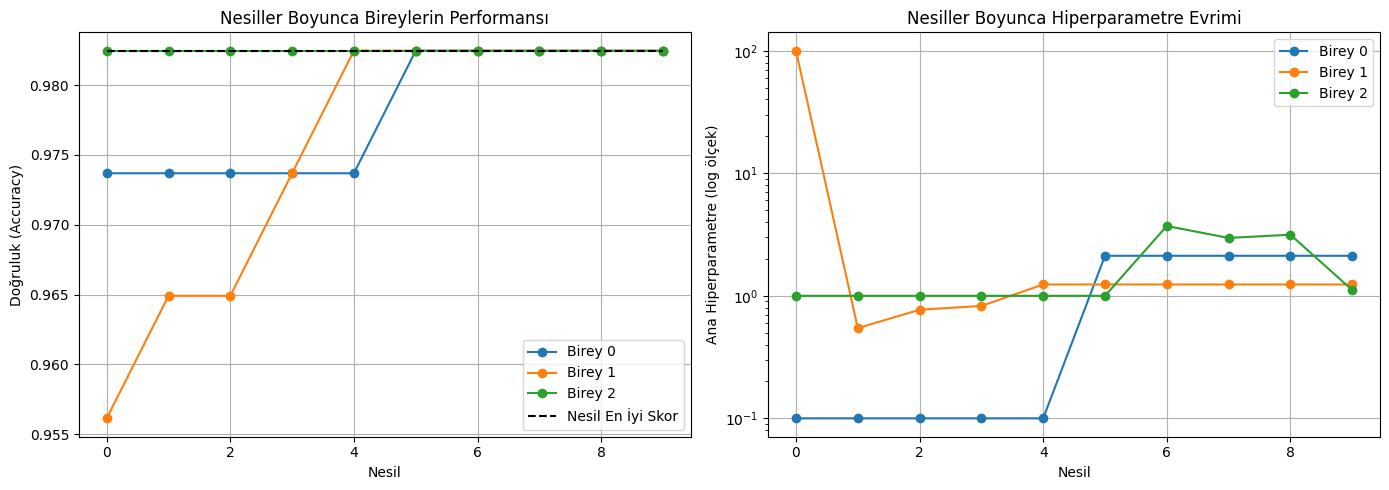

In [ ]:
#sonuç özeti

print("\n=== Son Nesil Sonuç Özeti ===")
for ind in population:
    print(f"Birey {ind['id']} | Tip={ind['model_type']} | "
          f"Skor={ind['score']:.4f} | Parametreler={ind['params']}")

best_ind = max(population, key=lambda x: x["score"])
print(f"\nGenel En İyi Birey: {best_ind['id']} | "
      f"Tip={best_ind['model_type']} | Skor={best_ind['score']:.4f} | "
      f"Parametreler={best_ind['params']}")

#gorsellestirme

gens = np.arange(n_generations)

plt.figure(figsize=(14, 5))

#nesiller boyunca bireylerin doğrulukları
plt.subplot(1, 2, 1)
for ind_id, scores in scores_history.items():
    plt.plot(gens, scores, marker="o", label=f"Birey {ind_id}")
plt.plot(gens, best_history, "--", color="black", label="Nesil En İyi Skor")
plt.xlabel("Nesil")
plt.ylabel("Doğruluk (Accuracy)")
plt.title("Nesiller Boyunca Bireylerin Performansı")
plt.legend()
plt.grid(True)

#nesiller boyunca ana hiperparametre (model tipine göre)
plt.subplot(1, 2, 2)
for ind_id, hp_vals in main_hp_history.items():
    plt.plot(gens, hp_vals, marker="o", label=f"Birey {ind_id}")
plt.yscale("log")
plt.xlabel("Nesil")
plt.ylabel("Ana Hiperparametre (log ölçek)")
plt.title("Nesiller Boyunca Hiperparametre Evrimi")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()